# Wine Quality EDA (Regression task)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel

In [31]:
# Import data from local files
df_white = pd.read_csv('Data/winequality-white.csv', sep=';')
df_red = pd.read_csv('Data/winequality-red.csv', sep=';')

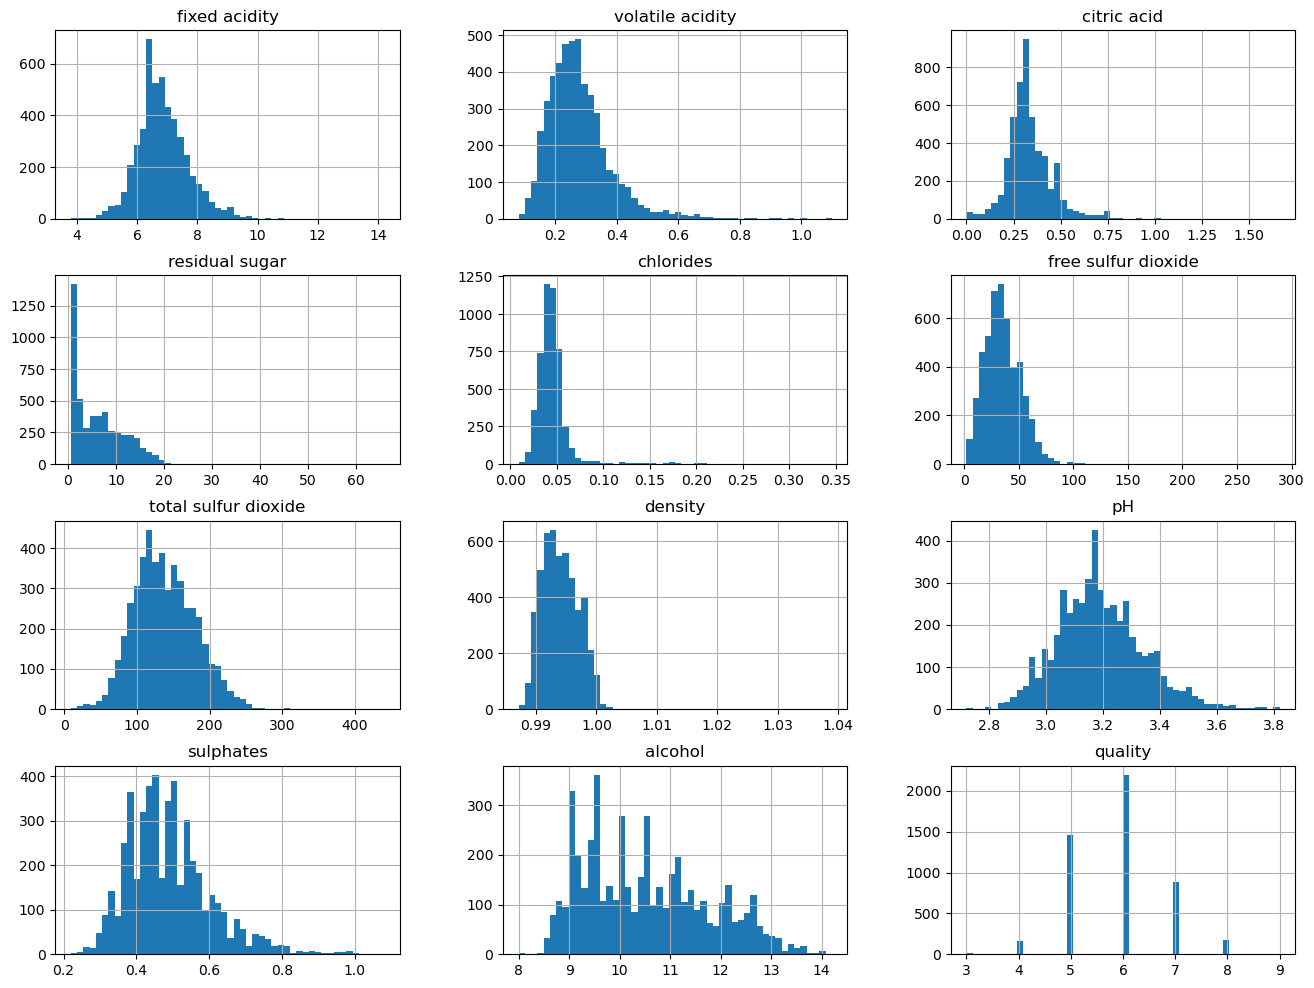

In [32]:
df_white.hist(bins=50, figsize=(16,12))
plt.show()

<Figure size 700x400 with 0 Axes>

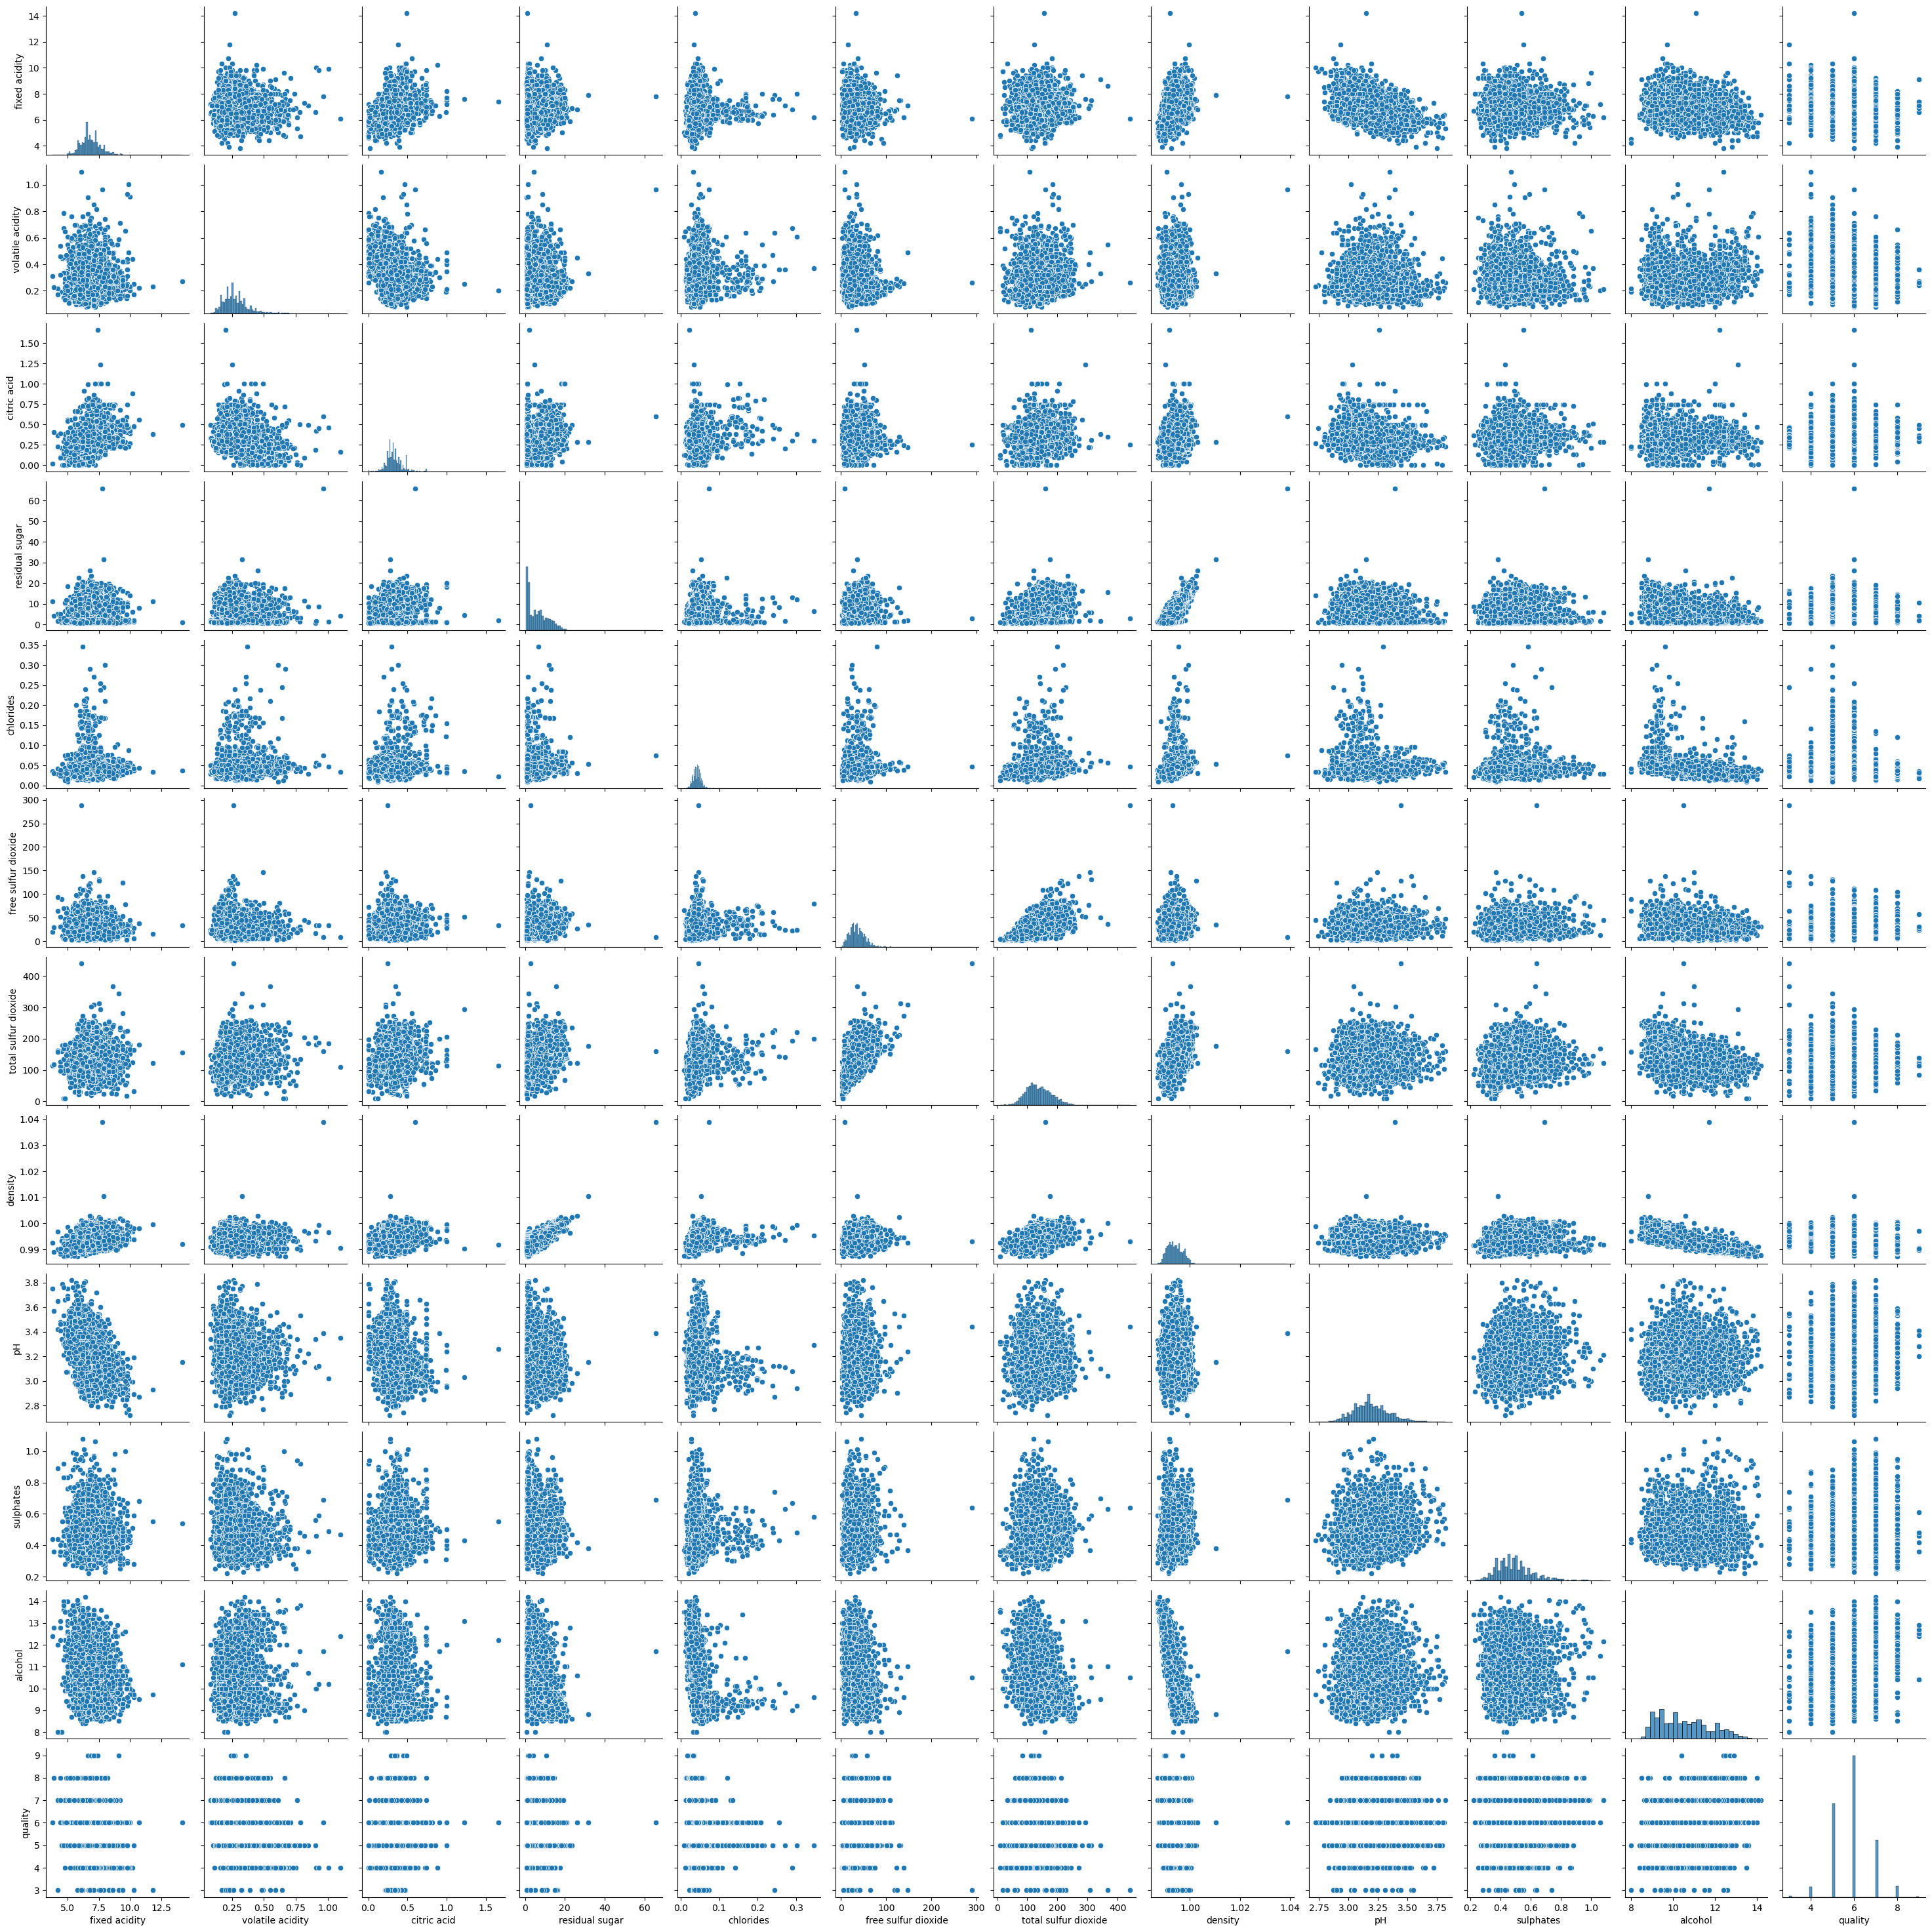

In [5]:
# Pairwise plot features
plt.figure(figsize=(7,4)) 
sns.pairplot(df_white)
plt.show()

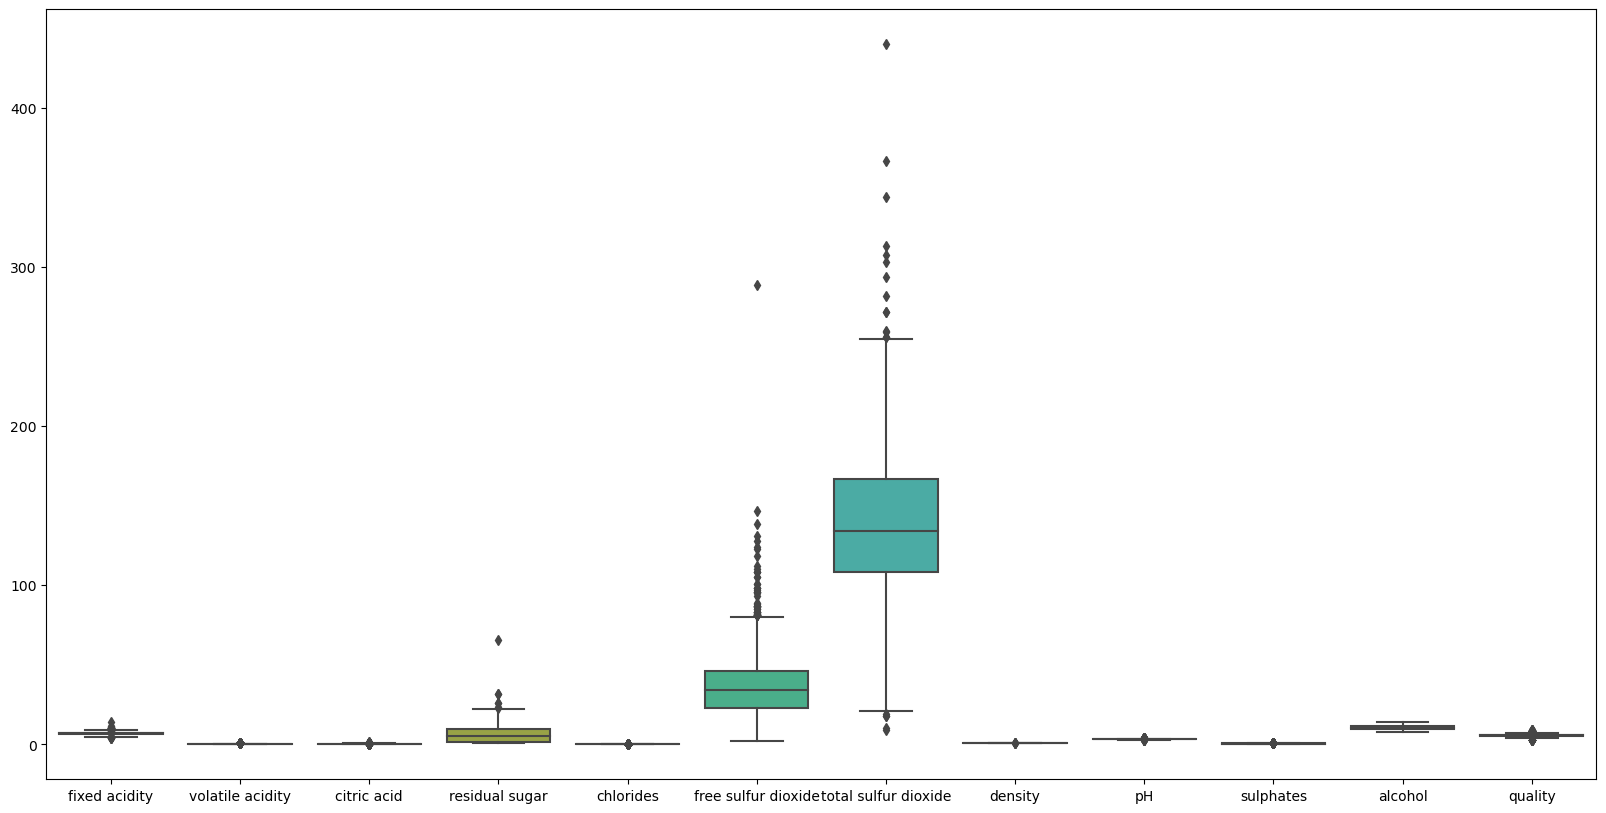

In [6]:
# Boxplot features to find outliers
plt.figure(figsize = (20, 10))
sns.boxplot(data = df_white)
plt.show()

In [7]:
# Remove outliers from dataset
def remove_outliers(df, col):
    q_1 = df[col].quantile(0.25)
    q_3 = df[col].quantile(0.75)
    iqr = q_3 - q_1

    lower = q_1 - (1.5 * iqr)
    upper = q_3 + (1.5 * iqr)
    
    df_new = df[(df[col] > lower) & (df[col] < upper)]

    return df_new
    

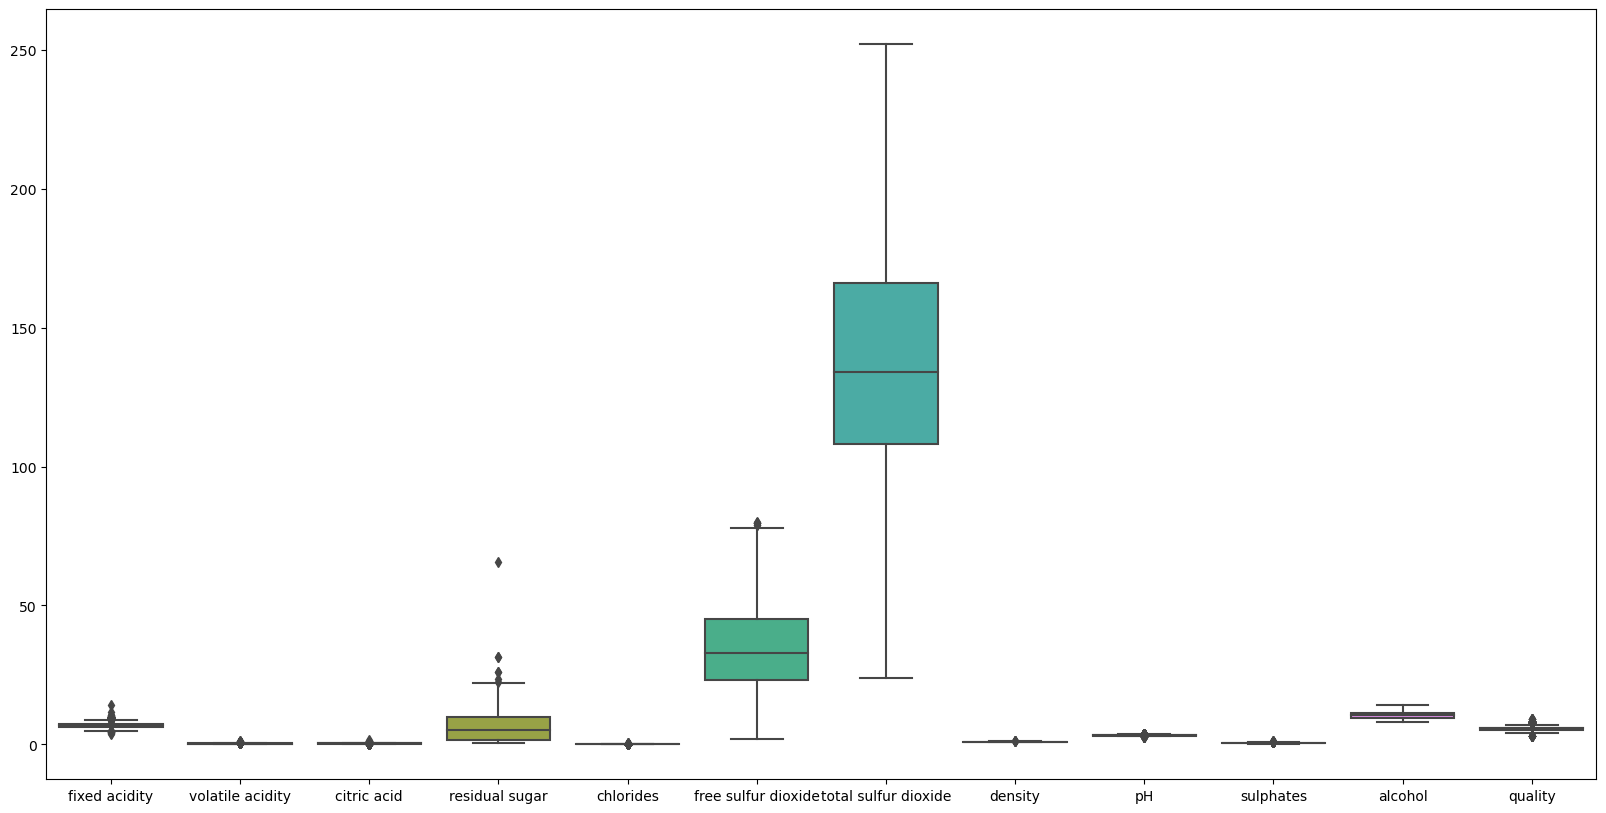

In [8]:
# Remove free/total sulfur dioxide outliers
df_no_outliers = remove_outliers(df_white, "free sulfur dioxide")
df_no_outliers = remove_outliers(df_no_outliers, "total sulfur dioxide")

# Compare boxplot now without outliers
plt.figure(figsize = (20, 10))
sns.boxplot(data = df_no_outliers)
plt.show()

In [10]:
# Split data into training and test sets
train_w, test_w = train_test_split(df_white, test_size = 0.2, random_state = 42)
train_r, test_r = train_test_split(df_red, test_size = 0.2, random_state = 42)

X_test = test_w.copy().drop("quality", axis=1)
Y_test = test_w["quality"]
X_train = train_w.copy().drop("quality", axis=1)
Y_train = train_w["quality"]

[0.0675261  0.12670142 0.06445393 0.06683573 0.06364671 0.10941272
 0.06936162 0.07349364 0.06897066 0.06449168 0.22510578]


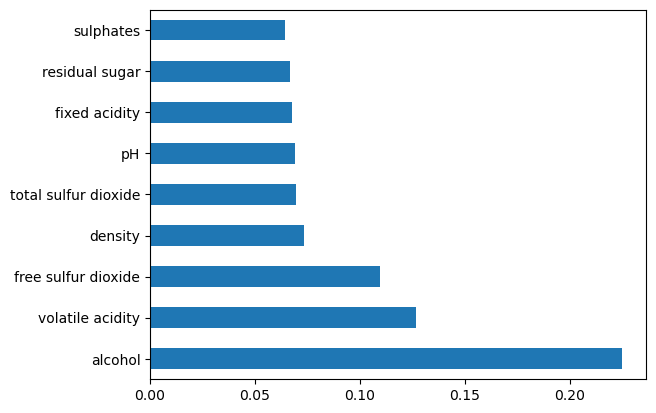

In [14]:
# Find most important features with extra trees regressor
etr = ExtraTreesRegressor(n_estimators=100, random_state=40)
etr.fit(X_train, Y_train)

# Plot the 9 most important features
important_feats = pd.Series(etr.feature_importances_, index=X_train.columns)
print(etr.feature_importances_)
important_feats = important_feats.nlargest(9)
important_feats.plot(kind = "barh")
plt.show()

In [15]:
# Save a separate csv of the whole white wine dataset but 
# With only these features and
# Without outliers
important_feats = list(important_feats.index)
important_feats.append('quality')

df_white_prep = df_no_outliers[important_feats]
print(np.unique(df_white_prep['quality']))
df_white_prep.to_csv("Data/prep-winequality-white.csv")


[3. 4. 5. 6. 7. 8. 9.]


In [140]:
def transform_wine(df, transform_cols):
    
    X_train_transform = df.copy()
    
    # Create and apply log transform for heavy tail distributions
    for col in transform_cols:
        log_transform = FunctionTransformer(np.log1p, validate=True)
        X_train_transform[[col]] = log_transform.transform(df[[col]])
        
    
    return X_train_transform
    

In [142]:
# Function to try different attribute combinations 
def make_attr_combos(df, cols, op):
    new_cols = []
    new_col_names = []
    
    for attr_1 in cols:
        for attr_2 in cols:
            if (attr_1 != attr_2):
                col_name = attr_1 + op + attr_2
                
                if  (attr_2 + op + attr_1) not in new_col_names:
                    new_col_names.append(col_name)

                    if op == '/':
                        new_attr = df[attr_1]/df[attr_2]
                    elif op == '*':
                        new_attr = df[attr_1]*df[attr_2]

                    new_cols.append(list(new_attr.values))
    
    new_cols = np.array(new_cols).transpose()
    new_attrs_df = pd.DataFrame(new_cols, columns = new_col_names)

    return new_attrs_df

In [147]:
def top_corr(df, account_new_attrs, n_cols=-1):
    # Find and plot top 3 feature correlations to quality
    corr_matrix = df.corr()
    
#     print(op)
#     if account_new_attrs:
#         corr_all = corr_matrix["quality"].sort_values(ascending=False)
#         corr_all_cols = corr_all.axes[0]
#         corr_unq_cols = []
        
#         #corr_unq_cols = [ corr for corr in corr_all_cols ]
        
#         for corr_col in corr_all_cols:
#             if (corr_col == 'quality'):
#                 corr_unq_cols.append(corr_col)
#             else:
#                 attr_1 = corr_col.split(op)[0]
#                 attr_2 = corr_col.split(op)[1]
#                 if not ((any(attr_1 in unq_cols for unq_cols in corr_unq_cols)) and (any(attr_2 in unq_cols for unq_cols in corr_unq_cols))):
#                     corr_unq_cols.append(corr_col)     
        
#         print("unq:\n")
#         print(corr_unq_cols)
#         print("corr_matrix:\n")
#         print(corr_matrix)
#         corr_high = corr_matrix[[corr_unq_cols]][0:4]
#         corr_high_cols = corr_high.axes[0]
#     else:
#         corr_high = corr_matrix["quality"].sort_values(ascending=False)[0:4]
#         corr_high_cols = corr_high.axes[0]

    
    corr_high = corr_matrix["quality"].sort_values(ascending=False)
    if (n_cols > 0): corr_high = corr_high[0:n_cols+1] 
    corr_high_cols = corr_high.axes[0]
    print(corr_high)

    # Plot top 3 correlations in a scatter matrix
    scatter_matrix(df[corr_high_cols], figsize=(20,16))
    plt.show()
    
    return corr_high_cols[corr_high_cols != 'quality']

quality                1.000000
alcohol                0.431681
pH                     0.103161
sulphates              0.062008
free sulfur dioxide    0.028810
citric acid           -0.014022
Name: quality, dtype: float64


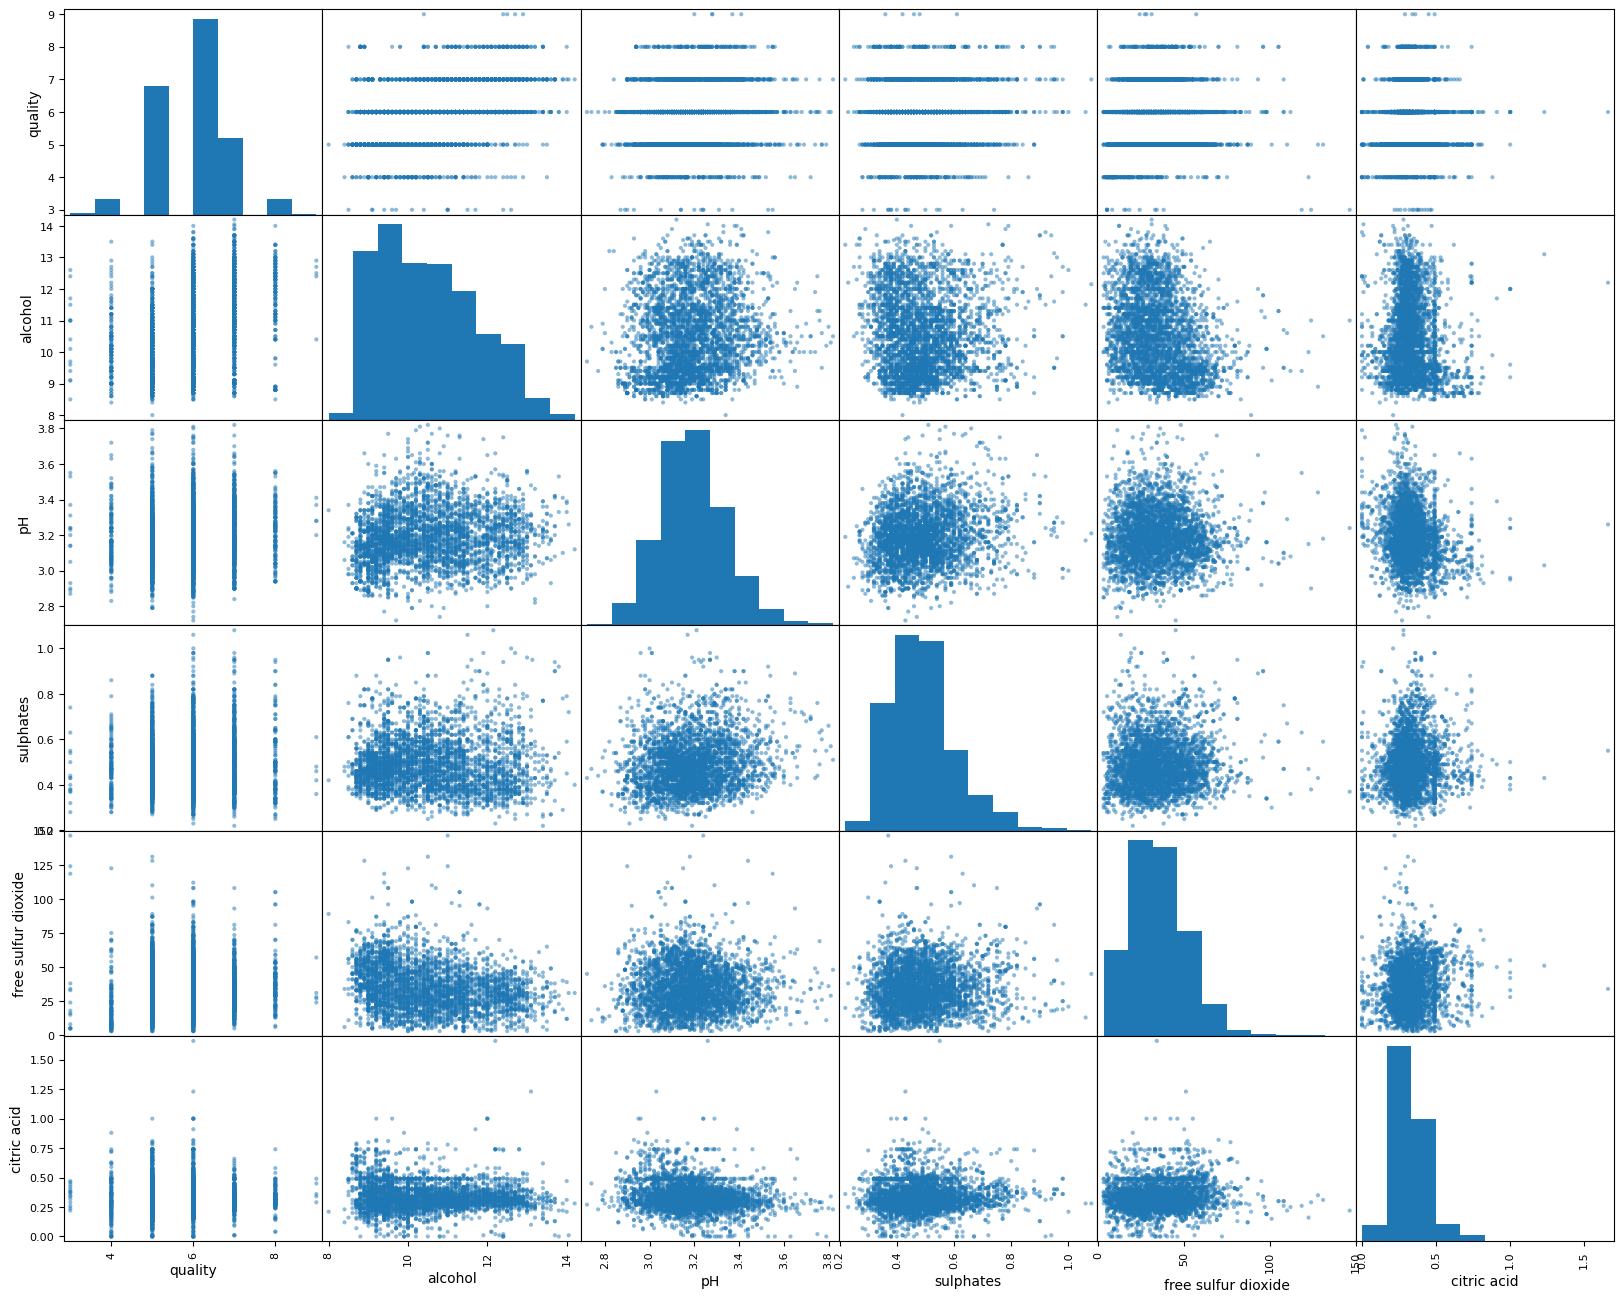

quality                            1.000000
sulphates*citric acid              0.039356
pH*citric acid                     0.034782
alcohol*citric acid                0.029507
pH*sulphates                       0.019071
free sulfur dioxide*citric acid    0.016409
alcohol*sulphates                  0.012891
sulphates*free sulfur dioxide      0.004754
pH*free sulfur dioxide            -0.010161
alcohol*free sulfur dioxide       -0.012364
alcohol*pH                        -0.018078
Name: quality, dtype: float64


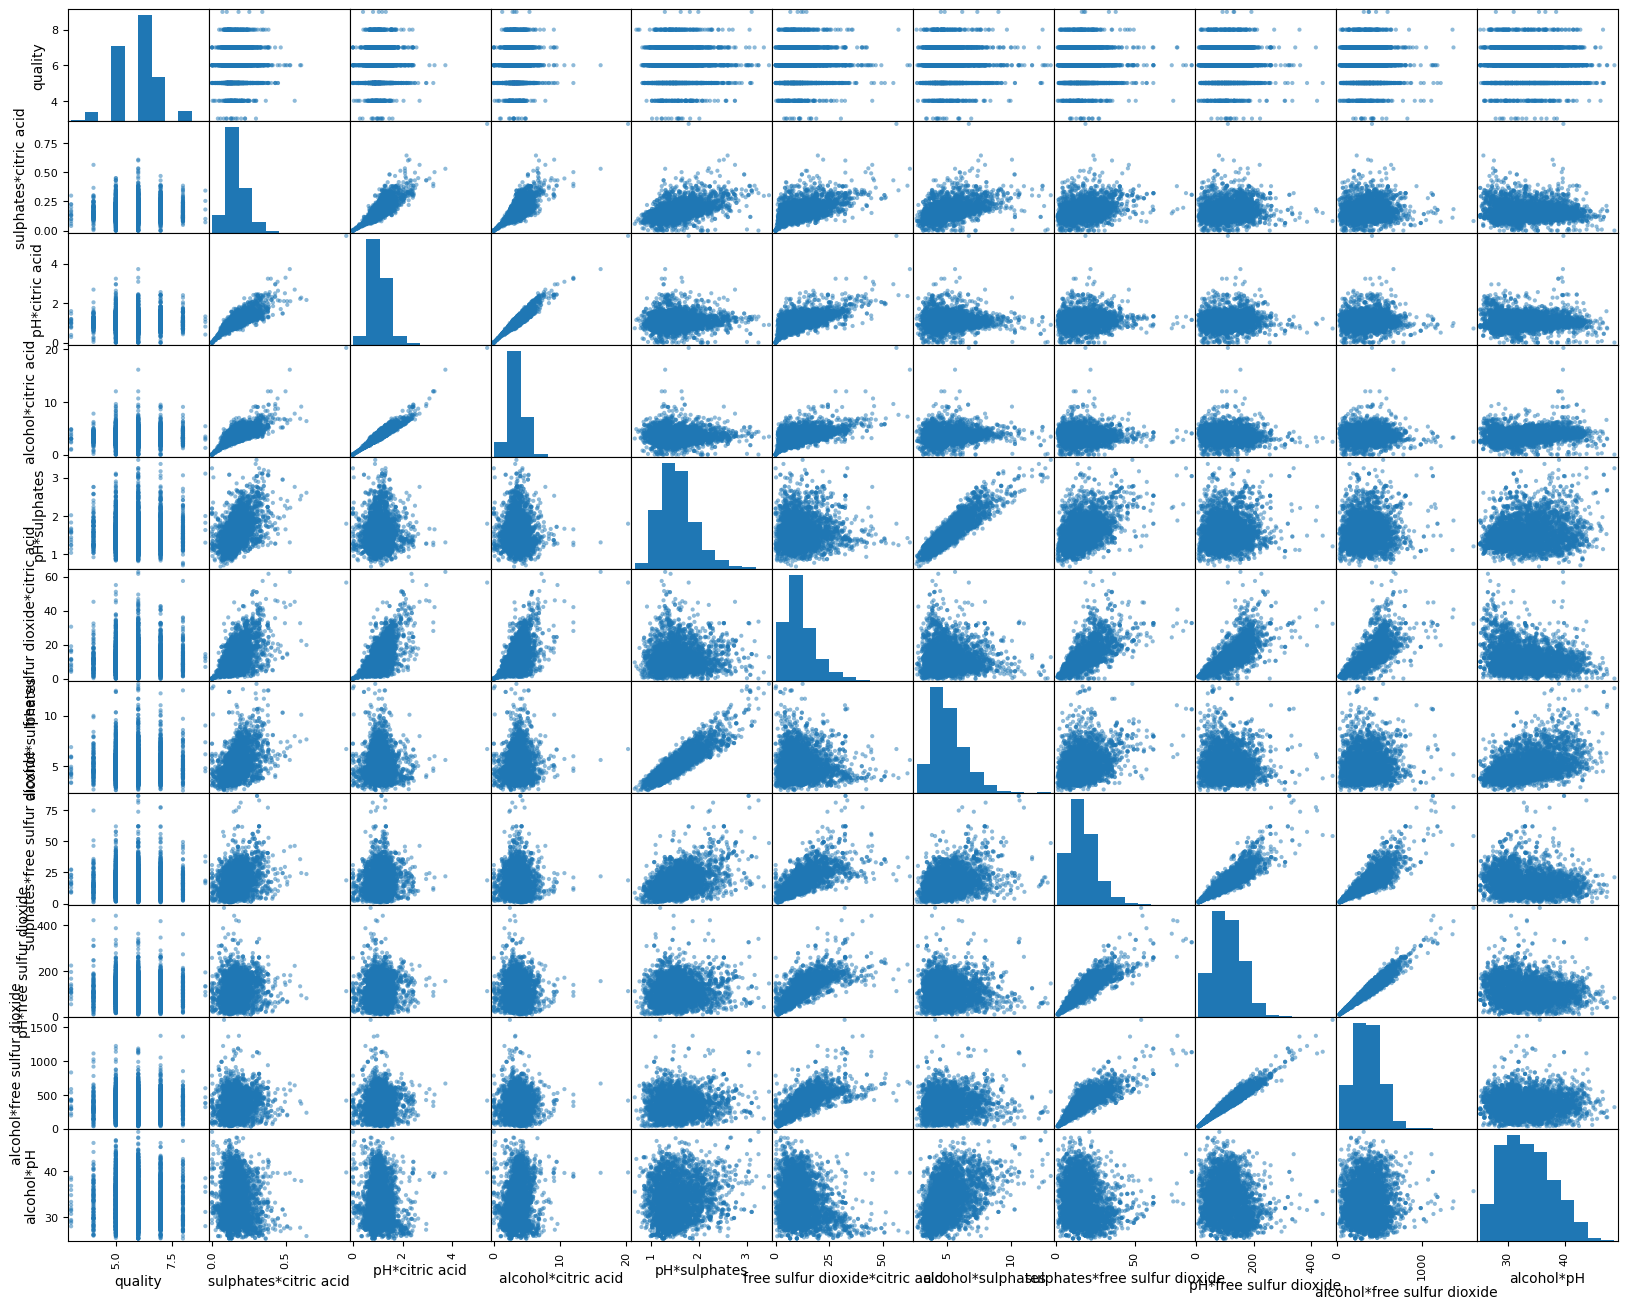

Index(['sulphates*citric acid', 'pH*citric acid', 'alcohol*citric acid',
       'pH*sulphates', 'free sulfur dioxide*citric acid', 'alcohol*sulphates',
       'sulphates*free sulfur dioxide', 'pH*free sulfur dioxide',
       'alcohol*free sulfur dioxide', 'alcohol*pH'],
      dtype='object')

In [148]:
# Find top 3 correlations 
combo_cols = top_corr(train_w, False, 5)

# Create new features by multiplying top 3 correlations
op =  '*'
mult_attrs_train_w = make_attr_combos(train_w, combo_cols, op)
mult_attrs_train_w['quality'] = train_w['quality']
 
# Top 3 new feature correlations vs quality
top_corr(mult_attrs_train_w, True)


In [ ]:
# Transform existing features
transform_cols = ["residual sugar", "alcohol"]
trans_train_w = transform_wine(train_w, transform_cols)

# Top 3 transformed feature correlations vs quality
top_corr(trans_train_w)



# Create new features from transformed features
attrs_trans_train_w = make_attr_combos(trans_train_w, combo_cols, '*')
attrs_trans_train_w['quality'] = train_w['quality']

# Top 3 transformed feature correlations vs quality
top_corr(attrs_trans_train_w)

In [133]:
# Scale the rest of the features
# Swap in the transformed features
X_train = X_train.drop(columns = transform_cols)
X_train = pd.concat([X_train, X_train_transform], axis=1)

# Min-max scaling


(4702, 14)
(3918, 5)


More feature engineering/selection
View feature combinations
Scale/normalize features
Decision trees